/home/matti/DATA/Mayonese/staggered_run/
header = ['Step' 'N_Drop' 'Vd/Vt' 'Push']
pushing factor = [[1.00e-04 0.00e+00 7.00e+00]
 [0.00e+00 6.00e+00 2.00e+01]
 [2.00e-05 1.90e+01 2.80e+01]
 [0.00e+00 2.70e+01 7.00e+02]
 [1.00e-06 6.99e+02 7.60e+02]
 [1.00e-05 7.59e+02 7.84e+02]
 [0.00e+00 7.83e+02 1.46e+03]]
number outputs : 1200
38.81334083357538


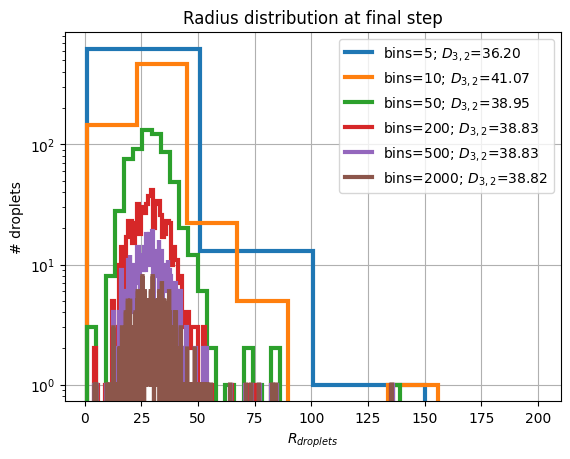

In [58]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

LOG_DISTRIB = 0;

#direc = "/home/matti/DATA/Mayonese/staggered_run_halfZ_doubleX/"; Nx=1024; Ny=512; Nz=256; start_move = 40000; dt=1000
#direc = "/home/matti/DATA/Mayonese/staggered_run_halfZ/"; Nx=512; Ny=512; Nz=256; start_move = 40000; dt=1000
direc = "/home/matti/DATA/Mayonese/staggered_run/"; Nx=512; Ny=512; Nz=512; start_move = 30000; dt=500
#direc = "/home/matti/DATA/Mayonese/staggered_run_1.5Z/"; Nx=512; Ny=512; Nz=768; start_move = 30000; dt=1000

print(direc)

bool_direc = direc!="/home/matti/DATA/Mayonese/staggered_run/"
bool_direc1024 = direc=="/home/matti/DATA/Mayonese/staggered_run_halfZ_doubleX/"

def find_push(f):
    change_indices = np.where(np.diff(f) != 0)[0] + 1
    segment_indices = np.concatenate(([0], change_indices, [len(f)]))
    result = []
    for i in range(len(segment_indices) - 1):
        value = f[segment_indices[i]]
        start_idx = segment_indices[i] - 1
        end_idx = segment_indices[i + 1] -2
        result.append([value, start_idx, end_idx+2])
    result = np.array(result)
    result[result<0] = 0
    return result
name  = "output.csv"
head  = np.genfromtxt(direc+name, delimiter=',\t', dtype=str,   max_rows=1)
A     = np.genfromtxt(direc+name, delimiter=',\t', dtype=float, skip_header=True)
ps    = find_push(A[:, 3])
print(f"header = {head}")
print(f"pushing factor = {ps}")

name  = "avgz.out"
avgz  = np.loadtxt(direc+name)
first_out_shear = int(start_move / dt)
number_out = int(A[-1,0]/dt)
print(f"number outputs : {number_out}")

# primo e secondo elemento: step e number_droplets
# terzo e quarto elemento: avarage volume e total volume [non per il file posvel]
# il resto sono vol e surf delle droplets
def read_nonunif_col(f,bool_twotwo,bool_vol):
    first_two_columns = []
    second_two_columns = []
    matrix_data = []
    with open(f, 'r') as file:
        for line in file:
            elements = line.split()
            if bool_twotwo:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                second_two_columns.append([float(elements[2]), float(elements[3])]) 
                data = list(map(float, elements[4:]))
            else:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                data = list(map(float, elements[2:]))
            matrix_data.append(data)
    max_length = max(len(row) for row in matrix_data)
    matrix_data_padded = np.array([row + [0] * (max_length - len(row)) for row in matrix_data])
    if bool_twotwo and bool_vol:
        #matrix_data_padded = ((3.0/(4.0*np.pi))*matrix_data_padded)**(1.0/3.0)
        second_two_columns = ((3.0/(4.0*np.pi))*np.array(second_two_columns))**(1.0/3.0) # from volume to radius
    return np.array(first_two_columns).T, np.cbrt(3.0*matrix_data_padded/(4.0*np.pi)), np.array(second_two_columns).T
def binning(d, info, b, bin_type):
    max_drop_idx = np.argmax(info[1,:])
    max_d = 200; #max(d[max_drop_idx,:])+1; #max_d = ;
    min_d = 1; #min(d[max_drop_idx,:])-1; #min_d = 1e5;
    # print(max_d, min_d)
    if   bin_type=='log' : bins = np.logspace(np.log10(min_d), np.log10(max_d), num=b)
    elif bin_type=='lin' : bins = np.linspace(min_d, max_d, num=b)
    else : print('choose a binning type: log or lin')
    all_count = []; all_bin_edges = []; all_bin_centers = []
    size = len(d[:,0])
    for i in range(size):
        count, bin_edges = np.histogram(d[i,:], bins=bins)
        all_count.append(count); all_bin_edges.append(bin_edges)
        all_bin_centers.append(np.array([(all_bin_edges[i][j]+all_bin_edges[i][j+1])*0.5 for j in range(b-1)]))
    return np.array(all_count), np.array(all_bin_edges), np.array(all_bin_centers)
name = "droplets_volume_rho1.dat"
step_e_num, d_vol, avg_e_tot_vol = read_nonunif_col(direc+name, 1, 1)

save_dir = '/home/matti/Pictures/image_test/'
# BB = [50, 500, 5000]
BB = [5, 10, 50, 200, 500, 2000]

for B in BB:
    
    count_vol, bin_edges_vol, bin_centers_vol = binning(d_vol, step_e_num, B, 'lin')    
    
    D32num   = np.sum(count_vol[-1,:]*(2*bin_centers_vol[-1,:])**3)
    D32denum = np.sum(count_vol[-1,:]*(2*bin_centers_vol[-1,:])**2)
    D32_end = 0.5*D32num/D32denum
    
    # distribution of droplets volume at each steps
    _ = plt.figure(1)
    _ = plt.stairs(count_vol[-1,:], bin_edges_vol[-1,:], linewidth=3, label="bins=%d; $D_{3,2}$=%1.2f"%(B, D32_end))
    _ = plt.xlabel('$R_{droplets}$')
    _ = plt.ylabel('# droplets');# (normalized to max)')
    _ = plt.yscale('log')
    _ = plt.rc('axes', axisbelow=True)
    _ = plt.legend()
    _ = plt.grid(True)
    _ = plt.title('Radius distribution at final step')

    # print(d_vol[-1,:])
    
D32num   = np.sum((2*d_vol[-1,:])**3)
D32denum = np.sum((2*d_vol[-1,:])**2)
D32_end = 0.5*D32num/D32denum
print(D32_end) #ok

_ = plt.figure(1)
_ = plt.savefig(save_dir+"plot_bins_D32.png", bbox_inches='tight', dpi=300, format='png')